In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px

# Reading Data

In [160]:
def create_df():
    data = {'Source':[], 'Sink':[]}
    with open("train.txt", "r") as f:
        for line in f:
            line = f.readline().split("\t")
            data['Source'] += [line[0]]*(len(line)-1)
            data['Sink'] += line[1:]
    pd_data = pd.DataFrame(data=data)
    pd_data[['Source', 'Sink']] = pd_data[['Source', 'Sink']].apply(pd.to_numeric)
    pd_data = pd_data.drop_duplicates(keep=False)
    return pd_data

In [3]:
def read_test():
    return pd.read_csv("test-public.txt", delimiter="\t", index_col=0)

In [4]:
data = create_df()

In [5]:
data.to_csv("processed_train.csv", header=False, index=False)

In [5]:
len(set(data["Source"]))

9792

In [6]:
test = read_test()

In [7]:
test.head()

,Source,Sink
Id,,
1,3563811,3600160
2,2052043,1401960
3,4517994,1690636
4,1660006,4349447
5,581111,1882617


In [8]:
test.shape

(2000, 2)

# Data Analysis

In [10]:
# missing data in train comparing with test
non_exist = 0
test_people = set(test['Source'])
train_people = set(data['Source'])
train_people.update(set(data['Sink']))
for i in test_people:
    if i not in train_people:
        non_exist += 1
print(non_exist)

23


### Visualising using networkx

In [68]:
g=nx.read_edgelist('processed_train.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [92]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 2858508
Number of edges: 11690629
Average in degree:   4.0898
Average out degree:   4.0898


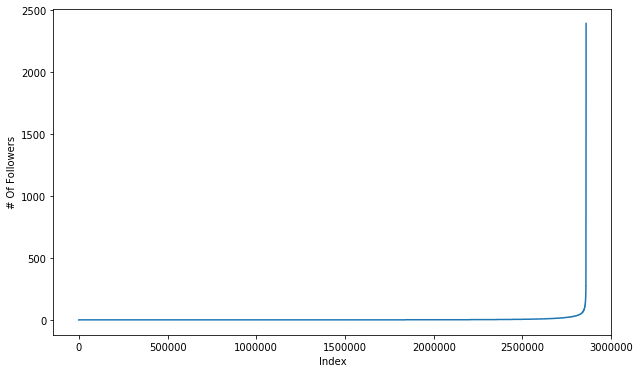

In [127]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index')
plt.ylabel('# Of Followers')
plt.show()

In [70]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist, 90+i))

90 percentile value is 7.0
91 percentile value is 8.0
92 percentile value is 10.0
93 percentile value is 11.0
94 percentile value is 13.0
95 percentile value is 16.0
96 percentile value is 20.0
97 percentile value is 25.0
98 percentile value is 34.0
99 percentile value is 51.0
100 percentile value is 2393.0


In [71]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 54.0
99.2 percentile value is 58.0
99.3 percentile value is 62.0
99.4 percentile value is 68.0
99.5 percentile value is 75.0
99.6 percentile value is 84.0
99.7 percentile value is 97.0
99.8 percentile value is 119.0
99.9 percentile value is 166.0
100.0 percentile value is 2393.0


In [77]:
print('# of persons who have no followers' ,sum(np.array(indegree_dist)==0),'and % is',
        sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

# of persons who have no followers 291 and % is 0.010180135931052143


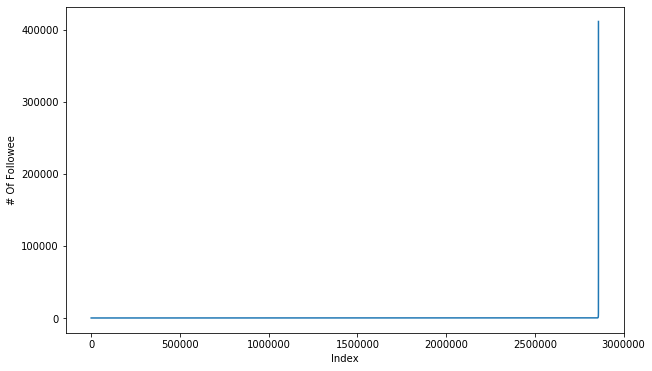

In [126]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index')
plt.ylabel('# Of Followee')
plt.show()

In [73]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist, 99+(i/100)))

99.1 percentile value is 0.0
99.2 percentile value is 0.0
99.3 percentile value is 0.0
99.4 percentile value is 0.0
99.5 percentile value is 0.0
99.6 percentile value is 0.0
99.7 percentile value is 26.0
99.8 percentile value is 116.0
99.9 percentile value is 381.0
100.0 percentile value is 411419.0


In [74]:
for i in range(900,1010,10):
    print(99+(i/1000),'percentile value is',np.percentile(outdegree_dist, 99+(i/1000)))

99.9 percentile value is 381.0
99.91 percentile value is 443.34370000008494
99.92 percentile value is 523.0
99.93 percentile value is 634.0451000002213
99.94 percentile value is 792.0
99.95 percentile value is 997.0
99.96 percentile value is 1352.5971999997273
99.97 percentile value is 1936.4479000000283
99.98 percentile value is 2736.8817999982275
99.99 percentile value is 6192.45099997893
100.0 percentile value is 411419.0


In [76]:
print('# of persons those are not following anyone are', sum(np.array(outdegree_dist)==0),'and % is',
        sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

# of persons those are not following anyone are 2848716 and % is 99.65744367341284


# Negative Data preparing and Train-validation split

In [93]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 2858508
Number of edges: 11690629
Average in degree:   4.0898
Average out degree:   4.0898


### generate random missing edge

In [97]:
import random
import csv
# getting the processed connection
raw_connection = csv.reader(open('processed_train.csv', 'r'))

exist_edges = {}

for edge in raw_connection:
    exist_edges[(edge[0], edge[1])] = 1

# in order to prevent overfitting, we generate the same number of negative edge
missing_edges = set()
while(len(missing_edges) < 11690629):
    a = random.randint(1, 2858508)
    b = random.randint(1, 2858508)
    if a == b:
        continue
        
    existance = exist_edges.get((a,b), -1)
    if existance == -1:
        try:
            # if distance within 2, that means they share a common follower and very likely to be friends in real world or at least know each others
            if nx.shortest_path_length(g, source=a, target=b) > 2:
                missing_edges.add((a,b))
            else:
                continue
        except:
            missing_edges.add((a,b))

In [98]:
len(missing_edges)

11690629

In [99]:
import pickle
pickle.dump(missing_edges, open('data/missing_edges_final.p', 'wb'))

### Train-Test Partition

In [105]:
negative_data = pd.DataFrame(list(missing_edges), columns=['Source', 'Sink'])

In [110]:
len(data)

11714162

In [111]:
len(negative_data)

11690629

In [120]:
from sklearn.model_selection import train_test_split
#Trian test split 
#positive links and negative links seperatly because we need positive training data only for creating graph and for feature generation
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(data, np.ones(len(data)), test_size=0.2, random_state=90051)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(negative_data, np.zeros(len(negative_data)), test_size=0.2, random_state=90051)

In [121]:
# !TODO the data is not perfectly balanced, maybe fixed this later
print('='*60)
print("Number of nodes in the train data graph with edges", y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", y_test_neg.shape[0])

Number of nodes in the train data graph with edges 9371329
Number of nodes in the train data graph without edges 9352503
Number of nodes in the test data graph with edges 2342833
Number of nodes in the test data graph without edges 2338126


In [122]:
#removing header and saving
X_train_pos.to_csv('data/train_pos.csv',header=False, index=False)
X_test_pos.to_csv('data/test_pos.csv',header=False, index=False)
X_train_neg.to_csv('data/train_neg.csv',header=False, index=False)
X_test_neg.to_csv('data/test_neg.csv',header=False, index=False)

In [123]:
X_train = X_train_pos.append(X_train_neg, ignore_index=True)
y_train = np.concatenate((y_train_pos, y_train_neg))
X_test = X_test_pos.append(X_test_neg, ignore_index=True)
y_test = np.concatenate((y_test_pos, y_test_neg))

In [178]:
#removing header and saving
X_train.to_csv('data/X_train.csv',header=False, index=False)
X_test.to_csv('data/X_test.csv',header=False, index=False)
pickle.dump(y_train, open('data/y_train.p', 'wb'))
pickle.dump(y_test, open('data/y_test.p', 'wb'))

# Feature Engineering

In [129]:
#generate train and test graph
train_graph = nx.read_edgelist('data/train_pos.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph = nx.read_edgelist('data/test_pos.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

print(nx.info(train_graph))
print(nx.info(test_graph))

# finding the unique nodes in the both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print('no of people common in train and test -- ',trY_teY)
print('no of people present in train but not present in test -- ',trY_teN)

print('no of people present in test but not present in train -- ',teY_trN)
print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 2476337
Number of edges: 9356337
Average in degree:   3.7783
Average out degree:   3.7783
Name: 
Type: DiGraph
Number of nodes: 993944
Number of edges: 2341878
Average in degree:   2.3561
Average out degree:   2.3561


In [130]:
def jaccard_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0 or len(set(train_graph.successors(b))) == 0:
            return 0
        else:
            intersection = len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
            union = len(set(train_graph.successors(a)).union(set(train_graph.successors(b))))
            return intersection/union
    except:
        return 0
    return sim

def jaccard_followers(a,b):
    try:
        if set(train_graph.predecessors(a)) == 0 or len(set(g.predecessors(b))) == 0:
            return 0
        else:
            intersection = len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b))))
            union = len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b))))
            return intersection/union
    except:
        return 0

In [133]:
#for followees
def cosine_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0 or len(set(train_graph.successors(b))) == 0:
            return 0
        else:
            return (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
    except:
        return 0
    
def cosine_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0 or len(set(train_graph.predecessors(b))) == 0:
            return 0
        else:
            return (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
    except:
        return 0

In [135]:
# caclulating the page rank for each node pair
pr = nx.pagerank(train_graph, alpha=0.85)
pickle.dump(pr,open('data/page_rank.p','wb'))
# use the mean for all the data points which are part of the test dataset but are not in the training dataset
mean_pr = float(sum(pr.values())) / len(pr)

print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean', mean_pr)

min 4.024692710545161e-07
max 5.266545198732145e-06
mean 4.0382225843064675e-07


In [136]:
def compute_shortest_path_length(a,b):
    p = -1
    try:
        # if the edge already exist, we first remove the edge which let our model better understand the graph
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [137]:
#getting weakly connected edges from graph 
wcc = list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a,b):
    index = []
    # they must belongs are there is a path
    if train_graph.has_edge(b,a):
        return 1
    
    if train_graph.has_edge(a,b):
        for i in wcc:
            if a in i:
                index = i
                break
        if b in index:
            train_graph.remove_edge(a,b)
            if compute_shortest_path_length(a,b) == -1:
                train_graph.add_edge(a,b)
                return 0
            else:
                train_graph.add_edge(a,b)
                return 1
        else:
            return 0
    else:
        for i in wcc:
            if a in i:
                index = i
                break
        if(b in index):
            return 1
        else:
            return 0

In [138]:
# Adar Index
def calc_adar_in(a,b):
    sum = 0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [139]:
# Test whether they are mutual followers
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [144]:
#Katz centrality of a node is a measure of centrality in a network
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz, open('data/katz.p','wb'))
mean_katz = float(sum(katz.values())) / len(katz)

print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean', mean_katz)

min 0.0005446404721043856
max 0.013375627968701433
mean 0.0006085911056278674


In [145]:
#HITS
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
pickle.dump(hits, open('data/hits.p','wb'))
mean_hits = float(sum(hits[0].values())) / len(hits[0])

print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean', mean_hits)

min 0.0
max 0.013661454011445197
mean 4.038222584405937e-07


In [182]:
X_train.shape

(18723832, 2)

In [192]:
# try to reduce the sample size, TODO, might fix this later
desire_train = 500000
desire_test = 50000
d_train = sorted(random.sample(range(1,len(X_train)+1), desire_train))
d_test = sorted(random.sample(range(1,len(X_test)+1), desire_test))

In [296]:
def shrink_df(df, label, num_list):
    if num_list == -1:
        return df, label
    desire_dict = {"Source":[], "Sink":[]}
    lb = []
    for i in num_list:
        desire_dict['Source'].append(df.loc[i]['Source'])
        desire_dict['Sink'].append(df.loc[i]['Sink'])
        lb.append(label[i])
    return pd.DataFrame(data=desire_dict), np.array(lb)

In [297]:
# X_desire_train, y_desire_train = shrink_df(X_train, y_train, d_train)
X_desire_train, y_desire_train = shrink_df(X_train, y_train, -1)

In [298]:
# X_desire_test, y_desire_test = shrink_df(X_test, y_test, d_test)
X_desire_test, y_desire_test = shrink_df(X_test, y_test, -1)

In [299]:
print(len(X_desire_train), len(y_desire_train), len(X_desire_test), len(y_desire_test))

18723832 18723832 4680959 4680959


In [295]:
X_train_features = pd.DataFrame()
X_test_features = pd.DataFrame()

In [174]:
#mapping jaccrd followers to train and test data
X_train_features['jaccard_followers'] = X_desire_train.apply(lambda row:jaccard_followers(row['Source'], row['Sink']), axis=1)
X_test_features['jaccard_followers'] = X_desire_test.apply(lambda row:jaccard_followers(row['Source'], row['Sink']),axis=1)

#mapping jaccrd followees to train and test data
X_train_features['jaccard_followees'] = X_desire_train.apply(lambda row:jaccard_followees(row['Source'], row['Sink']), axis=1)
X_test_features['jaccard_followees'] = X_desire_test.apply(lambda row:jaccard_followees(row['Source'], row['Sink']), axis=1)

#mapping jaccrd followers to train and test data
X_train_features['cosine_followers'] = X_desire_train.apply(lambda row:cosine_followers(row['Source'], row['Sink']), axis=1)
X_test_features['cosine_followers'] = X_desire_test.apply(lambda row:cosine_followers(row['Source'], row['Sink']), axis=1)

#mapping jaccrd followees to train and test data
X_train_features['cosine_followees'] = X_desire_train.apply(lambda row:cosine_followees(row['Source'], row['Sink']), axis=1)
X_test_features['cosine_followees'] = X_desire_test.apply(lambda row:cosine_followees(row['Source'], row['Sink']), axis=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/apply.py", line 251, in apply_standard
    labels=labels)
  File "pandas/_libs/reduction.pyx", line 641, in pandas._libs.reduction.reduce
  File "pandas/_libs/reduction.pyx", line 141, in pandas._libs.reduction.Reducer.get_result
  File "pandas/_libs/properties.pyx", line 69, in pandas._libs.properties.AxisProperty.__set__
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 378, in _set_axis
    object.__setattr__(self, '_index', labels)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-174-dbe191f1d8f8>", line 6, in <module>
    X_train_features['jaccard_followees'] = X_t

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/apply.py", line 251, in apply_standard
    labels=labels)
  File "pandas/_libs/reduction.pyx", line 641, in pandas._libs.reduction.reduce
  File "pandas/_libs/reduction.pyx", line 141, in pandas._libs.reduction.Reducer.get_result
  File "pandas/_libs/properties.pyx", line 69, in pandas._libs.properties.AxisProperty.__set__
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 378, in _set_axis
    object.__setattr__(self, '_index', labels)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-174-dbe191f1d8f8>", line 6, in <module>
    X_train_features['jaccard_followees'] = X_t

TypeError: can only concatenate str (not "list") to str

In [179]:
def compute_features_stage1(df_final):
    #calculating # of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    
    for i, row in df_final.iterrows():
        try:
            s1 = set(train_graph.predecessors(row['Source']))
            s2 = set(train_graph.successors(row['Sink']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1 = set(train_graph.predecessors(row['Source']))
            d2 = set(train_graph.successors(row['Sink']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

X_train_features['num_followers_s'], X_train_features['num_followers_d'], \
X_train_features['num_followees_s'], X_train_features['num_followees_d'], \
X_train_features['inter_followers'], X_train_features['inter_followees'] = compute_features_stage1(X_desire_train)

X_test_features['num_followers_s'], X_test_features['num_followers_d'], \
X_test_features['num_followees_s'], X_test_features['num_followees_d'], \
X_test_features['inter_followers'], X_test_features['inter_followees'] = compute_features_stage1(X_desire_test)

NameError: name 'X_train_featuresn' is not defined

In [233]:
# mapping adar index
X_train_features['adar_index'] = X_desire_train.apply(lambda row: calc_adar_in(row['Source'], row['Sink']), axis=1)
X_test_features['adar_index'] = X_desire_test.apply(lambda row: calc_adar_in(row['Source'], row['Sink']), axis=1)

# mapping followback
X_train_features['follows_back'] = X_desire_train.apply(lambda row: follows_back(row['Source'], row['Sink']), axis=1)
X_test_features['follows_back'] = X_desire_test.apply(lambda row: follows_back(row['Source'], row['Sink']), axis=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-233-90a9aaeee638>", line 2, in <module>
    X_train_features['adar_index'] = X_desire_train.apply(lambda row: calc_adar_in(row['Source'], row['Sink']), axis=1)
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py", line 6487, in apply
    return op.get_result()
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()
  File "/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/pandas/core/apply.py", line 251, in apply_standard
    labels=labels)
  File "pandas/_libs/reduction.pyx", line 641, in pandas._libs.reduction.reduce
  File "pandas/_libs/reduction.pyx", line 146, in pandas._libs.reduction.Reducer.get_result
  File "<ipython-input-233

KeyboardInterrupt: 

In [ ]:
# mapping wcc
X_train_features['same_wcc'] = X_desire_train.apply(lambda row: belongs_to_same_wcc(row['Source'], row['Sink']), axis=1)
X_test_features['same_wcc'] = X_desire_test.apply(lambda row: belongs_to_same_wcc(row['Source'], row['Sink']), axis=1)

In [ ]:
X_train_features['same_wcc'] = X_desire_train.apply(lambda row: belongs_to_same_wcc(row['Source'], row['Sink']), axis=1)
X_test_features['same_wcc'] = X_desire_test.apply(lambda row: belongs_to_same_wcc(row['Source'], row['Sink']), axis=1)

In [240]:
X_train_features['shortest_path'] = X_desire_train.apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)
X_test_features['shortest_path'] = X_desire_test.apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)

KeyboardInterrupt: 

In [246]:
X_desire_train.loc[:1000].apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)

0       2
1       3
2       3
3       2
4       2
5       2
6      -1
7       3
8       2
9       3
10      2
11      3
12      2
13      3
14      2
15      2
16      2
17     -1
18      2
19     -1
20      3
21      3
22     -1
23      2
24      2
25      2
26      2
27      2
28      2
29      2
       ..
971     2
972     3
973    -1
974     2
975     3
976    -1
977     2
978     2
979     2
980     3
981     2
982     2
983     2
984     3
985    -1
986     2
987     2
988     3
989     2
990     3
991     2
992    -1
993     2
994     2
995     2
996     2
997     2
998     2
999     2
1000    2
Length: 1001, dtype: int64

In [247]:
X_train_features

,hubs_s,hubs_d,authorities_s,authorities_d,katz_s,katz_d,page_rank_s,page_rank_d
0,0.001551,0.000000,9.920813e-06,1.332897e-07,0.002359,0.000578,4.151537e-07,4.025168e-07
1,0.001423,0.000000,7.677276e-06,6.718561e-08,0.003645,0.000575,1.390055e-06,4.029182e-07
2,0.000237,0.000000,1.610814e-06,2.017867e-07,0.000896,0.000592,4.231805e-07,4.025442e-07
3,0.008738,0.000000,2.288198e-05,1.787900e-06,0.006316,0.000743,4.933222e-07,4.038442e-07
4,0.000013,0.000000,1.397992e-06,2.838494e-07,0.001401,0.000719,8.404494e-07,4.209908e-07
5,0.005134,0.000000,1.904213e-05,1.596363e-06,0.004332,0.000707,4.452633e-07,4.025535e-07
6,0.002718,0.000000,5.465505e-06,1.079842e-07,0.003679,0.000563,1.201818e-06,4.024703e-07
7,0.000110,0.000000,2.193249e-06,1.416164e-07,0.001066,0.000612,4.068163e-07,4.031239e-07
8,0.003833,0.000000,1.720992e-05,2.277068e-07,0.003557,0.000578,4.268907e-07,4.025621e-07
9,0.000322,0.000000,1.397081e-06,1.354183e-06,0.001275,0.000730,4.431871e-07,4.027583e-07


In [ ]:
X_desire_test.apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)

In [300]:
X_train_features['page_rank_s'] = X_desire_train['Source'].apply(lambda x:pr.get(x, mean_pr))
X_train_features['page_rank_d'] = X_desire_train['Sink'].apply(lambda x:pr.get(x, mean_pr))
X_test_features['page_rank_s'] = X_desire_test['Source'].apply(lambda x:pr.get(x, mean_pr))
X_test_features['page_rank_d'] = X_desire_test['Sink'].apply(lambda x:pr.get(x, mean_pr))

In [301]:
#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
X_train_features['katz_s'] = X_desire_train['Source'].apply(lambda x: katz.get(x,mean_katz))
X_train_features['katz_d'] = X_desire_train['Sink'].apply(lambda x: katz.get(x,mean_katz))
X_test_features['katz_s'] = X_desire_test['Source'].apply(lambda x: katz.get(x,mean_katz))
X_test_features['katz_d'] = X_desire_test['Sink'].apply(lambda x: katz.get(x,mean_katz))

In [302]:
#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
X_train_features['hubs_s'] = X_desire_train['Source'].apply(lambda x: hits[0].get(x,0))
X_train_features['hubs_d'] = X_desire_train['Sink'].apply(lambda x: hits[0].get(x,0))
X_test_features['hubs_s'] = X_desire_test['Source'].apply(lambda x: hits[0].get(x,0))
X_test_features['hubs_d'] = X_desire_test['Sink'].apply(lambda x: hits[0].get(x,0))

In [303]:
X_train_features['authorities_s'] = X_desire_train['Source'].apply(lambda x: hits[1].get(x,0))
X_train_features['authorities_d'] = X_desire_train['Sink'].apply(lambda x: hits[1].get(x,0))
X_test_features['authorities_s'] = X_desire_test['Source'].apply(lambda x: hits[1].get(x,0))
X_test_features['authorities_d'] = X_desire_test['Sink'].apply(lambda x: hits[1].get(x,0))

In [ ]:
pickle.dump(X_train_features, open('data/X_train_features.p','wb'))
pickle.dump(X_test_features, open('data/X_test_features.p','wb'))

# Build the model

In [248]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=90051)
lr_clf.fit(X_train_features, y_desire_train)

/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=90051, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [249]:
lr_clf.score(X_test_features, y_desire_test)

0.82204

In [304]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=5, random_state=90051, n_jobs=-1)
rf_clf.fit(X_train_features, y_desire_train)

/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=90051, verbose=0,
                       warm_start=False)

In [305]:
rf_clf.score(X_test_features, y_desire_test)

0.9656215745534195

In [263]:
rf_clf.predict_proba(X_test_features)

array([[3.01798982e-01, 6.98201018e-01],
       [7.36454726e-04, 9.99263545e-01],
       [1.65230909e-01, 8.34769091e-01],
       ...,
       [9.17684758e-01, 8.23152416e-02],
       [9.17684758e-01, 8.23152416e-02],
       [9.17684758e-01, 8.23152416e-02]])

# Genereate Submission

In [254]:
sub_data = pd.read_csv("test-public.txt", sep='\t', index_col=0)

In [255]:
sub_data.head()

,Source,Sink
Id,,
1,3563811,3600160
2,2052043,1401960
3,4517994,1690636
4,1660006,4349447
5,581111,1882617


In [273]:
X_sub = pd.DataFrame()

In [274]:
X_sub['page_rank_s'] = sub_data['Source'].apply(lambda x:pr.get(x, mean_pr))
X_sub['page_rank_d'] = sub_data['Sink'].apply(lambda x:pr.get(x, mean_pr))

In [275]:
X_sub['katz_s'] = sub_data['Source'].apply(lambda x: katz.get(x,mean_katz))
X_sub['katz_d'] = sub_data['Sink'].apply(lambda x: katz.get(x,mean_katz))

In [276]:
X_sub['hubs_s'] = sub_data['Source'].apply(lambda x: hits[0].get(x,0))
X_sub['hubs_d'] = sub_data['Sink'].apply(lambda x: hits[0].get(x,0))

In [277]:
X_sub['authorities_s'] = sub_data['Source'].apply(lambda x: hits[1].get(x,0))
X_sub['authorities_d'] = sub_data['Sink'].apply(lambda x: hits[1].get(x,0))

In [306]:
y_sub = rf_clf.predict_proba(X_sub)

In [311]:
y_sub

array([[0.90887781, 0.09112219],
       [0.90887781, 0.09112219],
       [0.90887781, 0.09112219],
       ...,
       [0.90887781, 0.09112219],
       [0.90887781, 0.09112219],
       [0.90887781, 0.09112219]])

In [312]:
sum(rf_clf.predict(X_sub))

609.0

In [313]:
result = pd.DataFrame(data={"Id":range(1,len(y_sub)+1), "Predicted":[x[1] for x in y_sub]})

In [314]:
result.to_csv('submissioin.csv', index=False)